## Install Modules

In [1]:
# visual c++, cmake - install in local machine
# pip install cmake
# pip install dlib-19.24.99-cp312-cp312-win_amd64.whl
# pip install face_recognition

In [2]:
import cv2

## Import Modules

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

## Highlight Facial Points in the Image

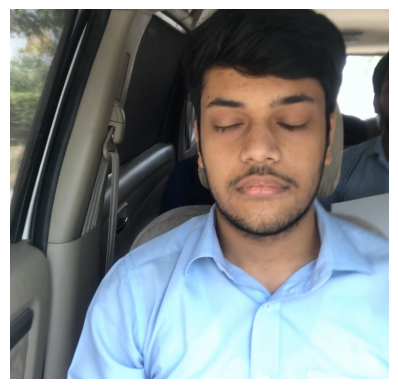

In [4]:
image_path = 'test1.png'
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [5]:
def highlight_facial_points(image_path):
    # load the image
    image_bgr = cv2.imread(image_path)
    # convert from bgr to rgb
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    face_locations = face_recognition.face_locations(image_rgb, model='cnn')

    for face_location in face_locations:
        # get facial landmarks
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    # plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


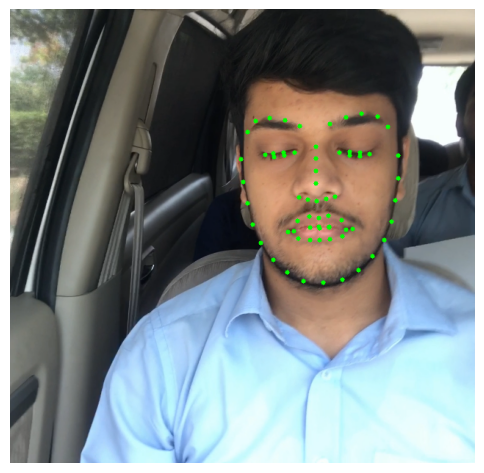

In [6]:
highlight_facial_points("test1.png")

<img src='facial_landmarks.png'>

In [7]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mount aspect ratio
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A+B) / (2.0 * C)
    return mar

In [8]:
def process_image(frame):
    # define thresholds
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find all face locations
    face_locations = face_recognition.face_locations(rgb_frame)

    # initiate flags
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        # check if eyes are closed
        if ear < EYE_AR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MOUTH_AR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

In [9]:
img = cv2.imread(image_path)
process_image(img)

(True, False)

## Real Time Drowsiness Detection

In [10]:
import time
video_path = "video/test.mp4"
# video_cap = cv2.VideoCapture(0) # for getting frames from the webcam
video_cap = cv2.VideoCapture(video_path)
count = score = 0
start_time = time.time()
while True:
    success, image = video_cap.read()
    if not success:
        break

    image = cv2.resize(image, (800, 500))
    rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # find all face locations
    # face_locations = face_recognition.face_locations(rgb_frame)

    # # initiate flags
    # eye_flag = mouth_flag = False

    # for face_location in face_locations:
    #     # extract facial landmarks
    #     landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
    #     # extract eye and mouth coordinates
    #     left_eye = np.array(landmarks['left_eye'])
    #     right_eye = np.array(landmarks['right_eye'])
    #     bot_mouth = np.array(landmarks['bottom_lip'])
    #     top_mount = np.array(landmarks['top_lip'])
        
    #     # calculate ear and mar
    #     left_ear = eye_aspect_ratio(left_eye)
    #     right_ear = eye_aspect_ratio(right_eye)
    #     ear = (left_ear+right_ear) / 2.0
    #     mar = mouth_aspect_ratio(bot_mouth)
    #     for point in left_eye:
    #             cv2.circle(image, tuple(point), 2, (0, 255, 0), -1)
    #     for point in right_eye:
    #         cv2.circle(image, tuple(point), 2, (0, 255, 0), -1)
    #     for point in bot_mouth:
    #         cv2.circle(image, tuple(point), 2, (255, 0, 0), -1)
    #     for point in top_mount:
    #         cv2.circle(image, tuple(point), 2, (255, 0, 0), -1)
    
    count += 1
    end_time = time.time()
    fps = count / (end_time - start_time)
    # process every nth frame
    n = 5
    if count % n == 0:
        eye_flag, mouth_flag = process_image(image)
        # if any flag is true, increment the score
        if eye_flag or mouth_flag:
            score += 1
        else:
            score -= 1
            if score < 0:
                score = 0
    # write the score values at bottom left of the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_x = 10
    text_y = image.shape[0] - 10
    text = f"Score: {score}"
    cv2.putText(image, text, (text_x, text_y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(image, f"fps: {fps}", (text_x, text_y - 20), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    if score >= 5:
        text_x = image.shape[1] - 130
        text_y = 40
        text = "Drowsy"
        cv2.putText(image, text, (text_x, text_y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow('drowsiness detection', image)

    # exit if any key is pressed
    if cv2.waitKey(1) & 0xFF != 255:
        break

video_cap.release()
cv2.destroyAllWindows()

In [11]:
# import cv2
# import numpy as np

# def draw_eye_direction(image):
#     # Tính toán tâm của mắt
#     # eye_center = np.mean(eye_points, axis=0).astype(int)
    
#     # # Tính toán bán kính của mắt dựa trên khoảng cách giữa các điểm
#     # eye_radius = int(np.linalg.norm(eye_points[0] - eye_points[3]) / 2)
    
#     # # Giả sử hướng nhìn là một vector từ tâm mắt đến một điểm nào đó
#     # # Ở đây, chúng ta giả định hướng nhìn thẳng về phía trước
#     # # Bạn có thể thay đổi vector này dựa trên phân tích của bạn
#     # gaze_vector = np.array([0, -1]) * eye_radius  # Hướng nhìn lên trên
    
#     # # Tính toán điểm kết thúc của mũi tên chỉ hướng nhìn
#     # gaze_endpoint = (eye_center + gaze_vector).astype(int)
    
#     # # Vẽ vòng tròn mô tả mắt
#     # cv2.circle(image, tuple(eye_center), eye_radius, (255, 0, 0), 2)
    
#     # # Vẽ mũi tên chỉ hướng nhìn
#     # cv2.arrowedLine(image, tuple(eye_center), tuple(gaze_endpoint), (0, 255, 0), 2)

#     for face_location in face_locations:
#         # extract facial landmarks
#         landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
#         # extract eye and mouth coordinates
#         left_eye = np.array(landmarks['left_eye'])
#         right_eye = np.array(landmarks['right_eye'])
#         bot_mouth = np.array(landmarks['bottom_lip'])
#         top_mount = np.array(landmarks['top_lip'])
        
#         # calculate ear and mar
#         left_ear = eye_aspect_ratio(left_eye)
#         right_ear = eye_aspect_ratio(right_eye)
#         ear = (left_ear+right_ear) / 2.0
#         mar = mouth_aspect_ratio(bot_mouth)
#         for point in left_eye:
#             cv2.circle(image, tuple(point), 2, (0, 255, 0), -1)
#         for point in right_eye:
#             cv2.circle(image, tuple(point), 2, (0, 255, 0), -1)
#         for point in bot_mouth:
#             cv2.circle(image, tuple(point), 2, (255, 0, 0), -1)
#         for point in top_mount:
#             cv2.circle(image, tuple(point), 2, (255, 0, 0), -1)
# # Ví dụ sử dụng
# # Đọc ảnh
# image = cv2.imread('test1.png')

# # Vẽ hướng nhìn cho mắt trái và phải
# draw_eye_direction(image)
# # draw_eye_direction(image, right_eye)

# # Hiển thị ảnh
# cv2.imshow('Eye Direction', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
